# George_AstroML_Fig8-10

In [106]:
import numpy as np
from matplotlib import pyplot as plt
import george
from george import kernels
from scipy.optimize import minimize
#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=12, usetex=True)


#------------------------------------------------------------
# define a squared exponential covariance function
def squared_exponential(x1, x2, h):
    return np.exp(-0.5 * (x1 - x2) ** 2 / h ** 2)

#------------------------------------------------------------
# draw samples from the unconstrained covariance
np.random.seed(1)
x = np.linspace(0, 10, 100)
h = 1.0

mu = np.zeros(len(x))
C = squared_exponential(x, x[:, None], h)
draws = np.random.multivariate_normal(mu, C, 3)


#------------------------------------------------------------
# Constrain the mean and covariance with two points
x1 = np.array([2.5, 7])
y1 = np.cos(x1)
k = 1.0*kernels.ExpSquaredKernel(metric=1)
gp1 = george.GP(k,  mean=np.mean(y1))
gp1.compute(x1, 0)

print(gp1.get_parameter_dict())
print("Initial ln-likelihood: {0:.2f}".format(gp1.log_likelihood(y1)))



# define the objective function and 
# its gradient 
def neg_ln_like(p,y,gp):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(y)

def grad_neg_ln_like(p,y,gp):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y)


result = minimize(neg_ln_like, gp1.get_parameter_vector(), jac=grad_neg_ln_like,
                 args = (y1, gp1))
print(result)
gp1.set_parameter_vector(result.x)
print("\nFinal ln-likelihood: {0:.2f}".format(gp1.log_likelihood(y1)))

f1, MSE1 = gp1.predict(y1, x, return_var=True)
f1_err = np.sqrt(MSE1)
print(gp1.get_parameter_dict())

# in George, the error is included in .compute call for calculation of the 
# covariance matrix 
dy2 = 0.2

gp2 = george.GP(k,  mean=np.mean(y1))
gp2.compute(x1, dy2)


print(gp2.get_parameter_dict())
print("Initial ln-likelihood: {0:.2f}".format(gp2.log_likelihood(y1)))

result = minimize(neg_ln_like, gp2.get_parameter_vector(), jac=grad_neg_ln_like,
                 args = (y1, gp2))
print(result)

gp2.set_parameter_vector(result.x)
print("\nFinal ln-likelihood: {0:.2f}".format(gp2.log_likelihood(y1)))


f2, MSE2 = gp2.predict(y1, x, return_var=True)
f2_err = np.sqrt(MSE2)

print(gp2.get_parameter_dict())


#------------------------------------------------------------
# Constrain the mean and covariance with many noisy points
x3 = np.linspace(0, 10, 20)
y3 = np.cos(x3)
dy3 = 0.2
y3 = np.random.normal(y3, dy3)



gp3 = george.GP(k,  mean=np.mean(y3))
gp3.compute(x3, dy3)

print(gp3.get_parameter_bounds())
print(gp3.get_parameter_dict())
print("Initial ln-likelihood: {0:.2f}".format(gp3.log_likelihood(y3)))

metric_min, metric_max = 0.1,5
bounds = [(None,None), (np.log(metric_min), np.log(metric_max))]
result = minimize(neg_ln_like, gp3.get_parameter_vector(), jac=grad_neg_ln_like,
                  args=(y3, gp3), bounds=bounds)
print(result)

gp3.set_parameter_vector(result.x)
print("\nFinal ln-likelihood: {0:.2f}".format(gp3.log_likelihood(y3)))


f3, MSE3 = gp3.predict(y3, x, return_var=True)
f3_err = np.sqrt(MSE3)


# we have fit for the `h` parameter: print the result here:
print("best-fit theta =", gp3.get_parameter_dict())





OrderedDict([('kernel:k1:log_constant', 0.0), ('kernel:k2:metric:log_M_0_0', 0.0)])
Initial ln-likelihood: -2.44
      fun: 2.334592846748191
 hess_inv: array([[  5.78684072e-01,   4.08516320e+01],
       [  4.08516320e+01,   2.11971383e+04]])
      jac: array([ -8.59324935e-06,   9.09733609e-07])
  message: 'Optimization terminated successfully.'
     nfev: 19
      nit: 17
     njev: 19
   status: 0
  success: True
        x: array([-0.50329281, -0.5020259 ])

Final ln-likelihood: -2.33
OrderedDict([('kernel:k1:log_constant', -0.50329281291257444), ('kernel:k2:metric:log_M_0_0', -0.50202590102462985)])
OrderedDict([('kernel:k1:log_constant', -0.50329281291257444), ('kernel:k2:metric:log_M_0_0', -0.50202590102462985)])
Initial ln-likelihood: -2.34
      fun: 2.3345928431109697
 hess_inv: array([[  1.15094737e+00,   1.09706554e-04],
       [  1.09706554e-04,   1.00000002e+00]])
      jac: array([  8.65093547e-07,   8.49497340e-07])
  message: 'Optimization terminated successfully.'
   

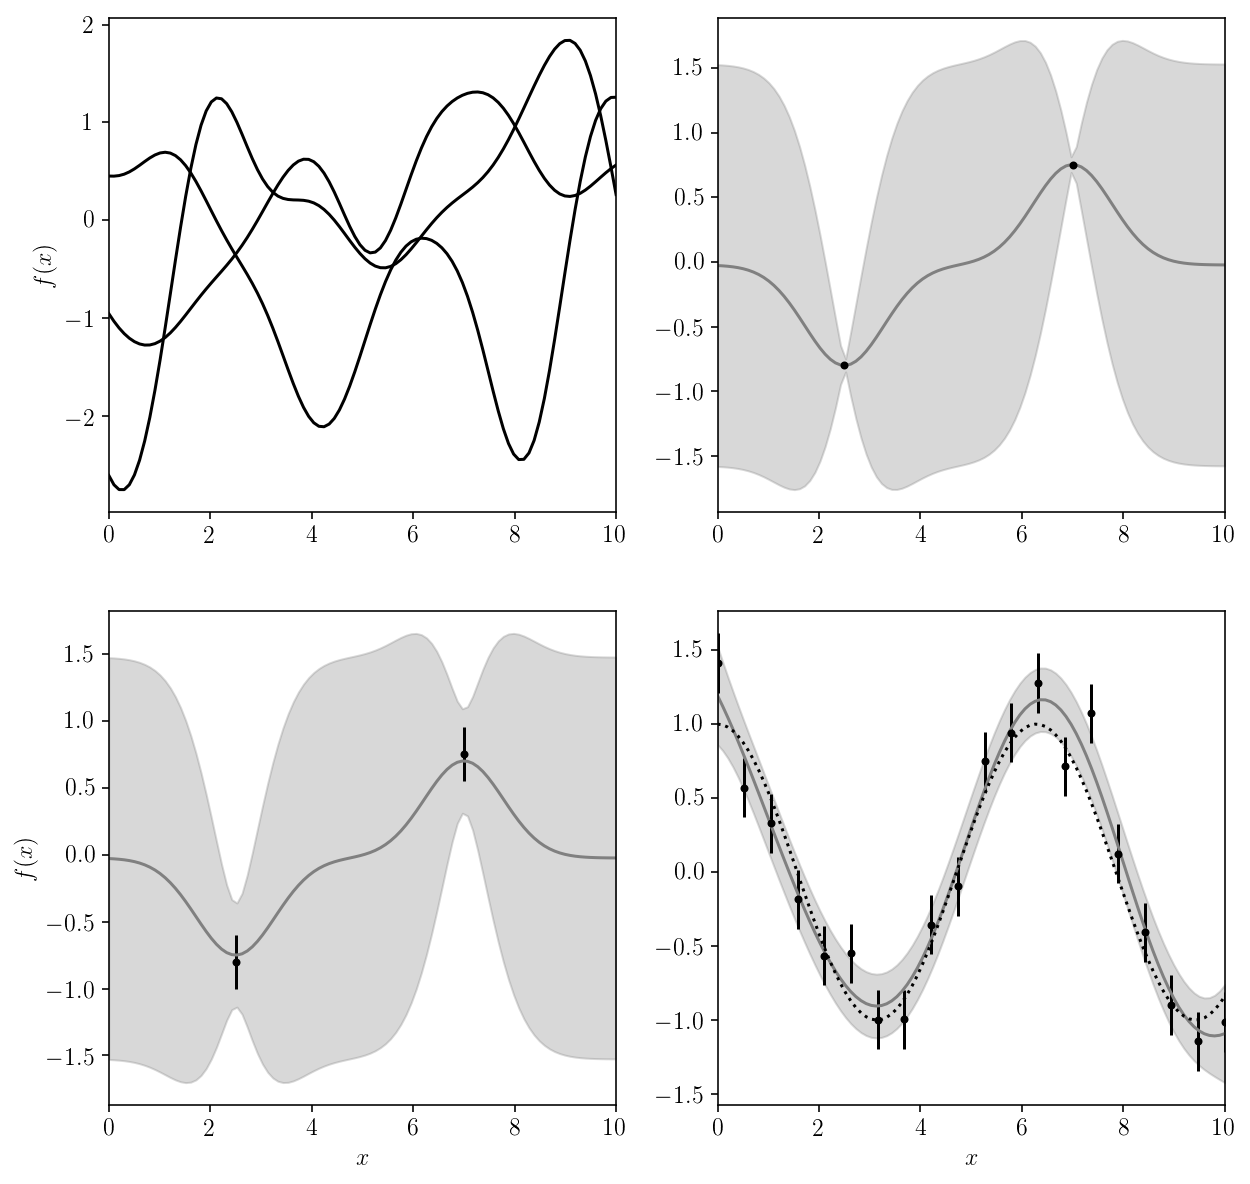

In [107]:


%matplotlib inline
#------------------------------------------------------------
# Plot the diagrams
fig = plt.figure(figsize=(10,10))
%config InlineBackend.figure_format='retina'

# first: plot a selection of unconstrained functions
ax = fig.add_subplot(221)
ax.plot(x, draws.T, '-k')
ax.set_ylabel('$f(x)$')

# second: plot a constrained function
ax = fig.add_subplot(222)
ax.plot(x, f1, '-', color='gray')
ax.fill_between(x, f1 - 2 * f1_err, f1 + 2 * f1_err, color='gray', alpha=0.3)
ax.plot(x1, y1, '.k', ms=6)

# third: plot a constrained function with errors
ax = fig.add_subplot(223)
ax.plot(x, f2, '-', color='gray')
ax.fill_between(x, f2 - 2 * f2_err, f2 + 2 * f2_err, color='gray', alpha=0.3)
ax.errorbar(x1, y1, dy2, fmt='.k', ms=6)

ax.set_xlabel('$x$')
ax.set_ylabel('$f(x)$')

# third: plot a more constrained function with errors
ax = fig.add_subplot(224)
ax.plot(x, f3, '-', color='gray')
ax.fill_between(x, f3 - 2 * f3_err, f3 + 2 * f3_err, color='gray', alpha=0.3)
ax.errorbar(x3, y3, dy3, fmt='.k', ms=6)

ax.plot(x, np.cos(x), ':k')

ax.set_xlabel('$x$')

for ax in fig.axes:
    ax.set_xlim(0, 10)


plt.savefig('AstroML_Fig8-10_George.png', bbox_inches='tight')